In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys
sys.path.append('../../')
import pymc3 as pm
import caustic as ca
import theano.tensor as T
import exoplanet as xo

mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['axes.titlesize'] = 22

%config InlineBackend.figure_format = 'retina'

np.random.seed(42)

In this example, we fit the same event with the same model as in the annual parallax example, except using dynamic nested sampling as implemented in [dynesty](https://dynesty.readthedocs.io/en/latest/index.html) instead of Hamiltonian Monte Carlo.

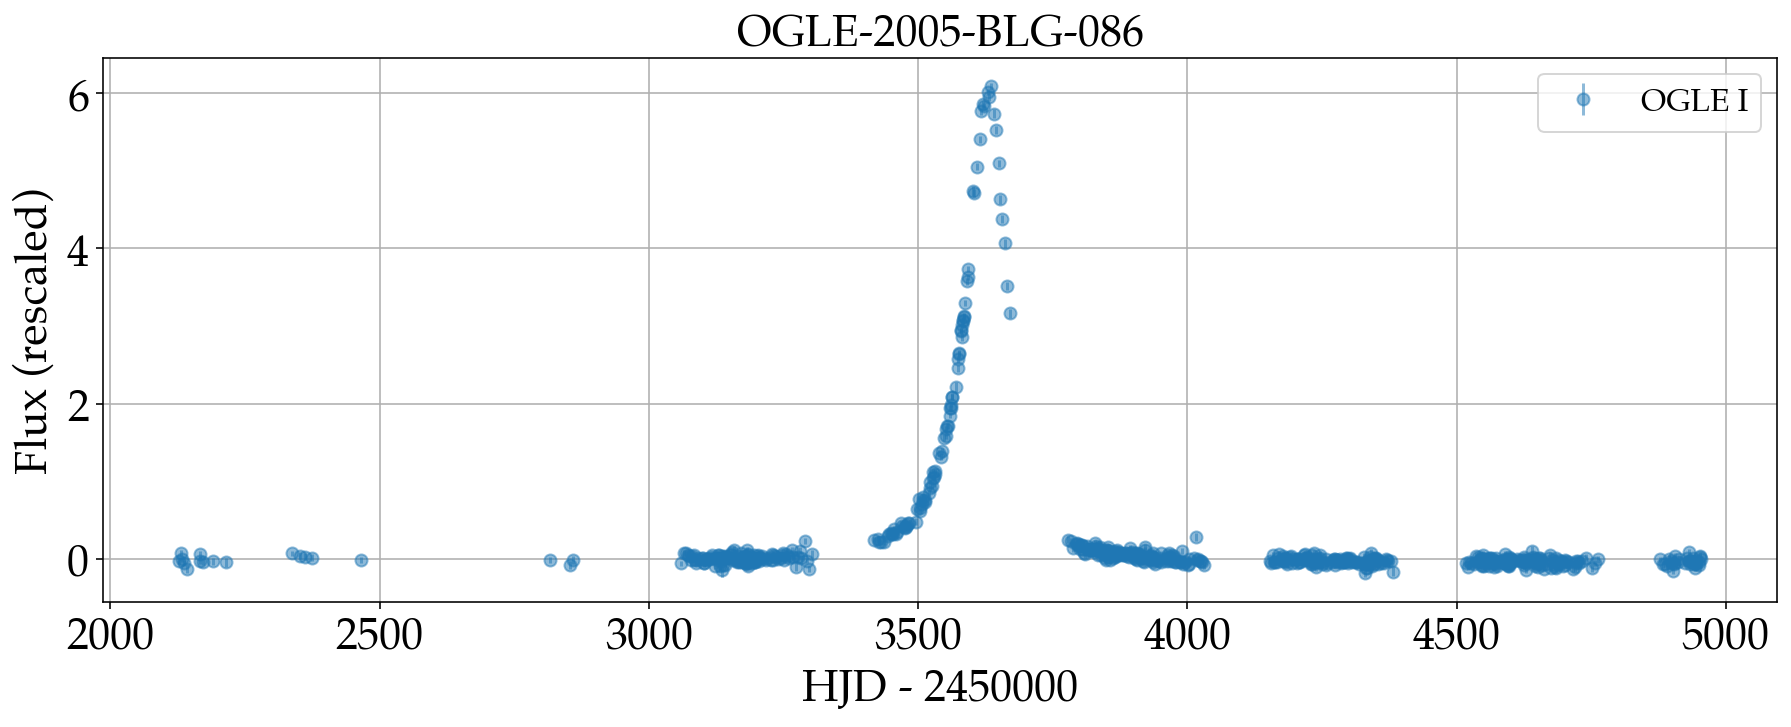

In [2]:
# Load event data
event_dir = '../../data/OB05086/'
event = ca.data.OGLEData(event_dir)

# Plot data 
fig, ax = plt.subplots(figsize=(15, 5))
event.plot_standardized_data(ax);

In [3]:
# Initialize a SingleLensModel object
parallax_model = ca.models.SingleLensModel(event) 

In [4]:
n_bands = len(event.light_curves)
BoundedNormal = pm.Bound(pm.Normal, lower=0.) 
BoundedNormal_1 = pm.Bound(pm.Normal, lower=1.) 

with parallax_model:
    # Flux parameters 
    Delta_F = BoundedNormal('Delta_F', 
        mu=T.zeros(n_bands),
        sd=50.*T.ones(n_bands),
        testval=5.*T.ones(n_bands),
        shape=(n_bands))

    F_base = pm.Normal('F_base', 
        mu=T.zeros(n_bands), 
        sd=0.6*T.ones(n_bands),
        testval=T.zeros(n_bands),
        shape=(n_bands))
    
    # Other parameters
    t_0 = pm.Uniform('t_0', parallax_model.t_min, parallax_model.t_max,
        testval=ca.utils.estimate_t0(event))    
    
    # In the parallax model, u_0 can be negative
    u_0 = pm.Normal('u_0', mu=0., sd=1.5, testval=-0.41)    
    teff = BoundedNormal('t_eff', mu=0., sd=365., testval=20.)
        
    # Initialize the two parallax parameters
    pi_EE = pm.Normal('pi_EE', mu=0., sigma=1., testval=0.1)
    pi_EN = pm.Normal('pi_EN', mu=0., sigma=1., testval=-0.3)
       
    # Deterministic transformations
    t_E = pm.Deterministic("t_E", teff/T.abs_(u_0)) 
    m_source, g = ca.utils.revert_flux_params_to_nonstandardized_format(event, Delta_F, F_base, u_0)
    pm.Deterministic("m_source", m_source)
    pm.Deterministic("g", g)
    pm.Deterministic('pi_E', T.sqrt(pi_EE**2 + pi_EN**2))

    # Compute the trajectory including parallax
    trajectory = ca.trajectory.Trajectory(event, t_0, u_0, t_E, pi_EE, pi_EN)
    u = trajectory.compute_trajectory(parallax_model.t)
    
    # Compute the magnification
    mag = parallax_model.compute_magnification(u, u_0)
    
    # Compute the mean model
    mean = Delta_F*mag + F_base
    
    # Let's allow for rescaling of the error bars by a constant factor 
    c_1 = BoundedNormal_1('c_1', 
        mu=T.ones(n_bands),
        sd=2.*T.ones(n_bands),
        testval=1.5*T.ones(n_bands),
        shape=(n_bands))   

    # Diagonal terms of the covariance matrix
    var_F = (c_1*parallax_model.sig_F)**2 
    
    # Compute the Gaussian log_likelihood, add it as a potential term to the model
    ll = parallax_model.compute_log_likelihood(parallax_model.F - mean, var_F)
    pm.Potential('log_likelihood', ll)
    
    pm.Deterministic("log_likelihood_", ll) 

In [5]:
print(parallax_model.vars)

[Delta_F_lowerbound__, F_base, t_0_interval__, u_0, t_eff_lowerbound__, pi_EE, pi_EN, c_1_lowerbound__]


To use dynamic nested sampling, we have to re write the priors in the form of a prior transfer function which maps i.i.d uniformly distributed parameters defined on a unit cube to our parameters of interest. The `ppf` function associated with probability distributions defined in `scipy.stats` does exactly that. To learn why this step is necessary, check out the [dynesty docs](https://dynesty.readthedocs.io/en/latest/quickstart.html#prior-transforms). 

In [6]:
import scipy

def prior_transform(u):
    """
    Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest.
    """
    x = np.array(u)  # copy u

    # Delta_F_lowerbound__
    x[0] = scipy.stats.norm.ppf(u[0], loc=2., scale=1.)
    
    # F_base__
    x[1] = scipy.stats.norm.ppf(u[1], loc=0., scale=0.5)
    
    # t_0_interval__
    x[2] = scipy.stats.norm.ppf(u[2], loc=0.1, scale=0.5)
    
    # u_0
    x[3] = scipy.stats.norm.ppf(u[3], loc=0., scale=1.)
    
    # t_eff_lowerbound__
    x[4] = scipy.stats.norm.ppf(u[4], loc=3., scale=2.)
    
    # pi_EE
    x[5] = scipy.stats.norm.ppf(u[5], loc=0., scale=0.5)
    
    # pi_EN
    x[6] = scipy.stats.norm.ppf(u[6], loc=0., scale=0.5)
    
    # c_1_lowerbound
    x[7] = scipy.stats.norm.ppf(u[7], loc=-3, scale=3.)

    return x

Let's run the sampling, this will take some time...

In [7]:
# This will take a long time
results, samples  = ca.utils.sample_with_dynesty(parallax_model, prior_transform,
                    sampler_kwargs={'sample':'rwalk'},
                    run_sampler_kwargs={'nlive_init':1000})

Model vars [Delta_F_lowerbound__, F_base, t_0_interval__, u_0, t_eff_lowerbound__, pi_EE, pi_EN, c_1_lowerbound__]


iter: 3616 | batch: 0 | bound: 1 | nc: 25 | ncall: 36082 | eff(%):  9.751 | loglstar:   -inf < -1871.645 <    inf | logz: -1881.949 +/-  0.139 | dlogz: 1681.811 >  0.010                             /anaconda3/envs/pymc3/lib/python3.6/site-packages/dynesty/sampling.py:215: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
iter: 3864 | batch: 0 | bound: 3 | nc: 25 | ncall: 42282 | eff(%):  8.927 | loglstar:   -inf < -1554.994 <    inf | logz: -1565.672 +/-  0.141 | dlogz: 1449.111 >  0.010                             /anaconda3/envs/pymc3/lib/python3.6/site-packages/dynesty/sampling.py:215: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
iter: 8235 | batch: 0 | bound: 36 | nc: 25 | ncall: 151944 | eff(%):  5.384 | loglstar:   -inf < -634.554 < 

The sampling appears to have converged according to internal criteria specified in dynesty with a total of ~20M likelihood calls, let's plot the diagnostics plots.

In [8]:
from dynesty import utils as dyfunc

def resample_samples(results):
    # Resample samples such that they have equal weight
    samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    new_samples = dyfunc.resample_equal(samples, weights)
    
    return new_samples

samples = resample_samples(results)

Let's plot the posterior over the $u_0$ parameter, which we expect to be multi-modal

Text(0.5, 0, '$u_0$')

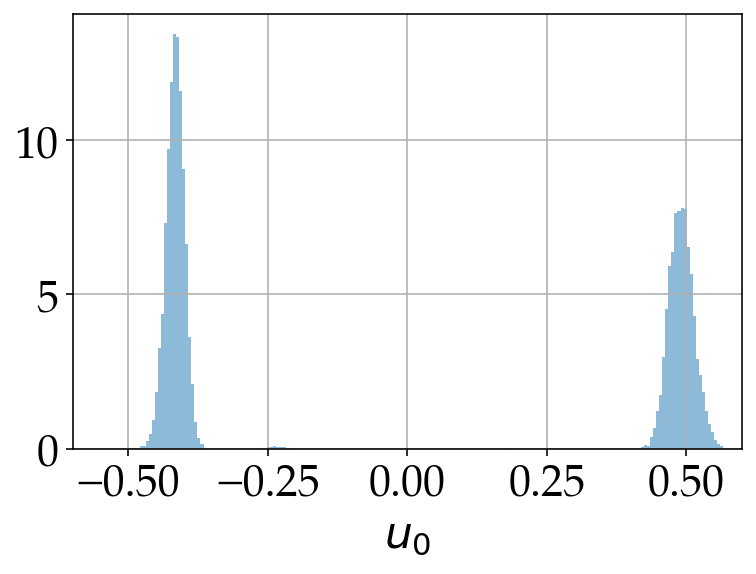

In [11]:
# Plot posterior for u_0
fig, ax = plt.subplots()

ax.hist(samples[: , 3], bins=200, density=True, alpha=0.5);
ax.set_xlim(-0.6, 0.6)
ax.grid()
ax.set_xlabel('$u_0$')

Looks like `dynesty` not only managed to discover both significant modes in the posterior, but also the relative height between the two modes matches what we've oberved in the [annual parallax example]().

Let's plot the model to check that it makes sense, and plot the posterior trajectories from the multi-modal pdf.

In [12]:
with parallax_model:
    # Create dense grid
    t_dense = np.tile(np.linspace(parallax_model.t_min, parallax_model.t_max, 1000), (n_bands, 1))
    t_dense_tensor = T.as_tensor_variable(t_dense) 
    
    # Evaluate trajectory components on dense grid
    u_n, u_e = trajectory.compute_trajectory(t_dense_tensor, return_components=True)   
    
    # Compute the magnification
    mag_dense = parallax_model.compute_magnification(T.sqrt(u_n**2 + u_e**2), u_0)
    
    # Compute the mean model
    mean_dense = Delta_F*mag_dense + F_base

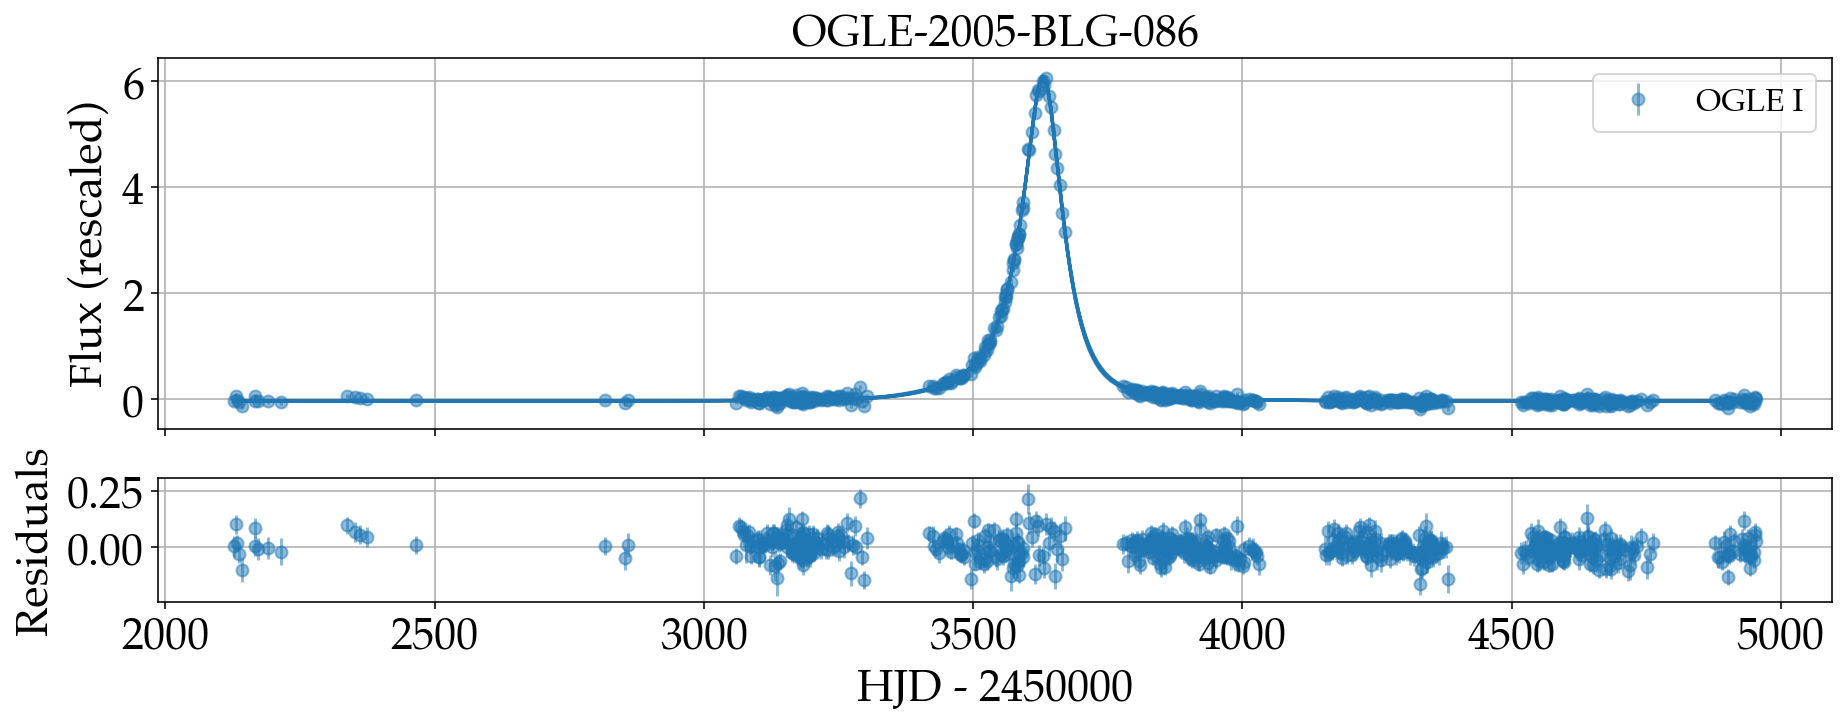

In [14]:
# Plot model
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios':[3,1]},
            figsize=(15, 5), sharex=True)

ca.utils.plot_model_and_residuals(ax, event, parallax_model, samples, t_dense_tensor, mean_dense, n_samples=50)

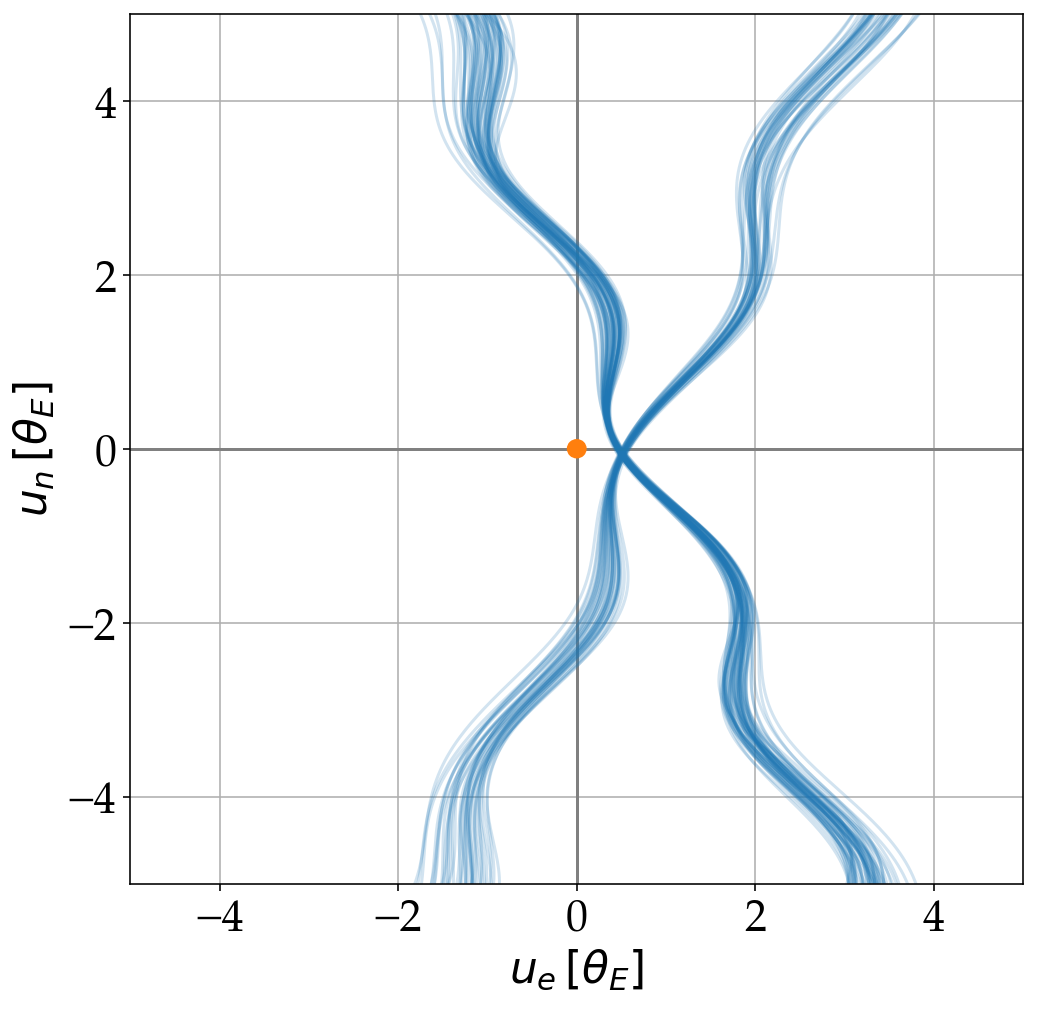

In [16]:
# Plot trajectory
fig, ax = plt.subplots(figsize=(8, 8))

ca.utils.plot_trajectory_from_samples(ax, event, parallax_model, samples,
    t_dense_tensor, u_n, u_e, n_samples=100, color='C0')

Looks good. Whereas in the parallax example with HMC we had to manually discover the different modes and had no idea about their relative importance, `dynesty` properly sampled the full pdf.